In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
trade_result = pd.read_csv('trade_result_finance_ASR_3_Num_30_ADF_3.csv')
trade_result['date_in'] = trade_result['date_in'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trade_result['date_out'] = trade_result['date_out'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trade_result['stock_1_profit'] = None
trade_result['stock_2_profit'] = None
trade_result['net_profit'] = None
trade_result.head()

,Unnamed: 0,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,...,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out,stock_1_profit,stock_2_profit,net_profit
0,"(2812, 2816)",-4.066761,NaN,4.096069,NaN,4.500381,NaN,2000-12-11,2000-12-18,1.236138,...,1.226712,NaN,3.39,78.27,4.360164,NaN,98.89,None,None,None
1,"(2816, 2834)",-3.012278,-2.052855,3.725501,4.098245,1.016279,0.262894,2000-12-18,2000-12-26,0.415200,...,4.594008,4.450503,85.67,9.69,2.271094,2.158715,8.66,None,None,None
2,"(2820, 2834)",-4.400714,-3.203096,4.360142,4.882985,7.866067,1.379970,2001-01-08,2001-01-15,0.658751,...,0.824175,0.966984,2.63,9.15,2.213754,2.244956,9.44,None,None,None
3,"(2812, 2836)",-3.290617,NaN,3.644844,NaN,1.456242,NaN,2001-02-05,2001-02-12,1.033131,...,1.506297,NaN,4.42,6.03,1.796747,NaN,6.03,None,None,None
4,"(2834, 2836)",-3.045359,NaN,3.138561,NaN,1.053250,NaN,2001-02-05,2001-02-12,1.972304,...,2.359910,NaN,10.26,6.03,1.796747,NaN,6.03,None,None,None


In [3]:
trade_result.groupby('reason').count()

,Unnamed: 0,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,...,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out,stock_1_profit,stock_2_profit,net_profit
reason,,,,,,,,,,,,,,,,,,,,,
cointegration_invalid,424,424,0,424,0,424,0,424,424,424,...,424,0,424,424,424,0,424,0,0,0
reversion,142,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,0,0,0
stop_loss,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,0,0,0
take_profit,216,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,0,0,0


# Define function and initial parameters

In [4]:
# transaction cost
cost_rate = 0.001425*0.6
tax_rate = 0.003

def calculate_profit(x):
    if x['spread_in'] > 0:
        # buy stock_1, short stock_2
        stock_1_profit = (
            x['stock_1_out'] - x['stock_1_in'] -
            cost_rate*(x['stock_1_in']+x['stock_1_out']) -
            tax_rate*(x['stock_1_out'])
        )*abs(x['hedge_ratio_in'])
        stock_2_profit = (
            x['stock_2_in'] - x['stock_2_out'] -
            cost_rate*(x['stock_2_in']+x['stock_2_out']) -
            tax_rate*(x['stock_2_out'])
        )*1000
    else:
        # short stock_1, buy stock_2
        stock_1_profit = (
            x['stock_1_in'] - x['stock_1_out'] -
            cost_rate*(x['stock_1_in']+x['stock_1_out']) -
            tax_rate*(x['stock_1_out'])
        )*abs(x['hedge_ratio_in'])
        stock_2_profit = (
            x['stock_2_out'] - x['stock_2_in'] -
            cost_rate*(x['stock_2_in']+x['stock_2_out']) -
            tax_rate*(x['stock_2_out'])
        )*1000

    total_profit = stock_1_profit + stock_2_profit
    
    return [stock_1_profit, stock_2_profit, total_profit]


def plot_equity_curve(select_result = None, figsize=(16, 8)):
    if select_result == None:
        temp_result = trade_result
        title = 'total result'
    else: 
        temp_result = trade_result[trade_result.reason.isin(select_result)]
        title = str(select_result)
    accumulate_profit = temp_result.net_profit.values.cumsum()

    # 找出創新高的index(要畫綠點)
    new_highest_index = []
    for i in range(len(accumulate_profit)):
        current_accumulate_profit = accumulate_profit[i]
        if i == 0:
            new_highest = accumulate_profit[i]
        if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
            new_highest = current_accumulate_profit
            new_highest_index.append(i)

    # 找出drawdown
    drawdown = []
    for i in range(len(accumulate_profit)):
        current_accumulate_profit = accumulate_profit[i]
        if i == 0:
            new_highest = accumulate_profit[i]
            drawdown.append(0)
        else:
            if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
                new_highest = current_accumulate_profit 
            if (current_accumulate_profit < new_highest):
                drawdown.append(current_accumulate_profit-new_highest)
            else:
                drawdown.append(0)
    
    print('   Net profit:   ', accumulate_profit[-1])
    print('   MDD:          ', min(drawdown))
    print('   Calmar ratio: ', accumulate_profit[-1]/abs(min(drawdown)))
    

    plt.style.use('seaborn')
    plt.figure(figsize=figsize)
    # 權益曲線
    plt.plot(accumulate_profit, c='black')
    # 創新高的點
    plt.scatter(new_highest_index,
                accumulate_profit[new_highest_index], c='#02ff0f', s=70)
    plt.title('Equity Curve - {}'.format(title[:]), size=20)
    plt.xlabel('Trade Number', size=15)
    plt.ylabel('NTD', size=15)
    plt.xticks(size=13)
    plt.yticks(size=13);

# Calculate profit

In [5]:
trade_result = trade_result.copy()
for i in range(len(trade_result)):
    temp_result = trade_result.iloc[i]
    trade_result.loc[i, ['stock_1_profit', 'stock_2_profit', 'net_profit']] = calculate_profit(temp_result)

In [6]:
win_loss_ratio = np.mean(trade_result[trade_result.net_profit > 0].net_profit) / np.mean(trade_result[trade_result.net_profit < 0].net_profit)
winning_rate = len(trade_result[trade_result.net_profit > 0]) / len(trade_result)
print('   Winning rate: ', winning_rate)
print('   Expection:   ', abs(win_loss_ratio)*winning_rate - (1-winning_rate))

   Winning rate:  0.47912087912087914
   Expection:    -0.0434610719236


# Visualization

   Net profit:    -27293.362289
   MDD:           -51918.5155528
   Calmar ratio:  -0.525696122056


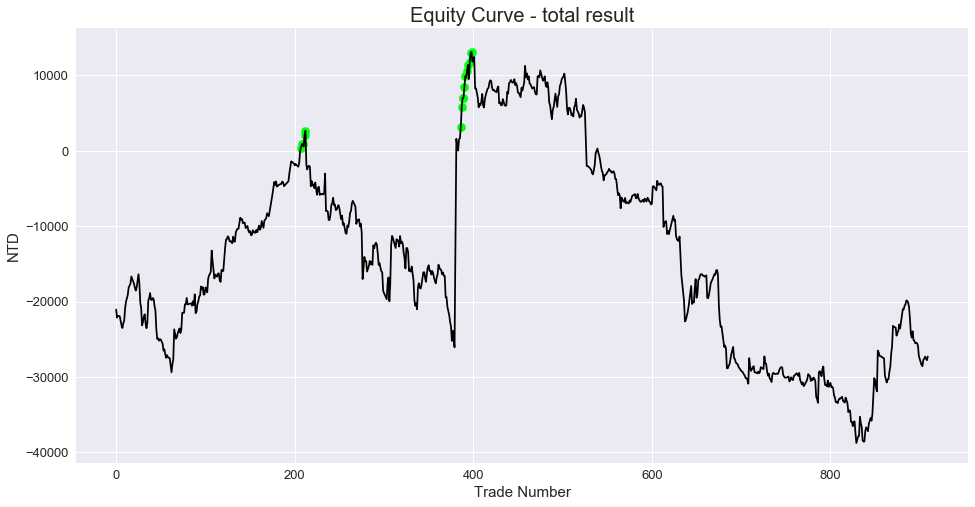

In [7]:
plot_equity_curve(None)

   Net profit:    51571.1819767
   MDD:           -6233.19159782
   Calmar ratio:  8.27363978266


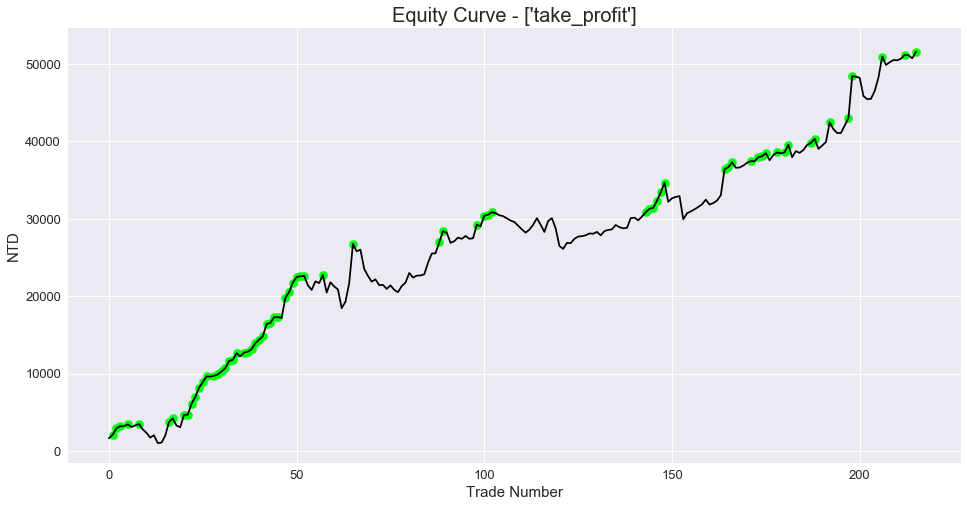

In [8]:
plot_equity_curve(['take_profit'])

   Net profit:    88050.031153
   MDD:           -4022.34593847
   Calmar ratio:  21.8902184198


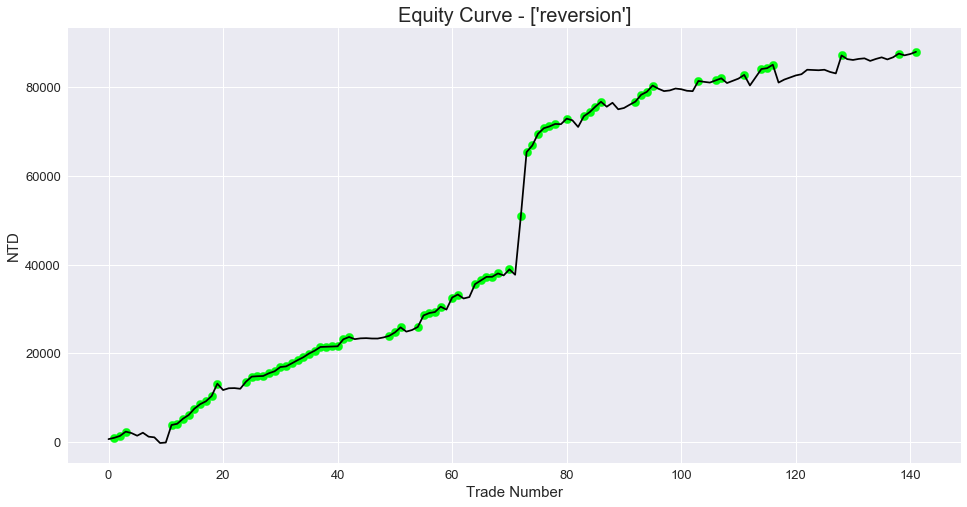

In [9]:
plot_equity_curve(['reversion'])

   Net profit:    -33593.490757
   MDD:           -33510.8017653
   Calmar ratio:  -1.00246753248


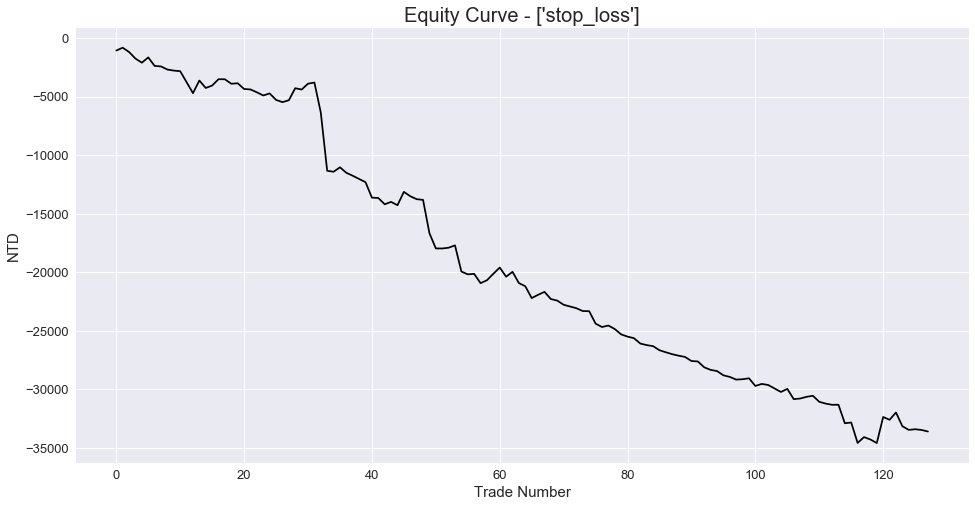

In [10]:
plot_equity_curve(['stop_loss'])

   Net profit:    -133321.084662
   MDD:           -112252.898381
   Calmar ratio:  -1.18768500934


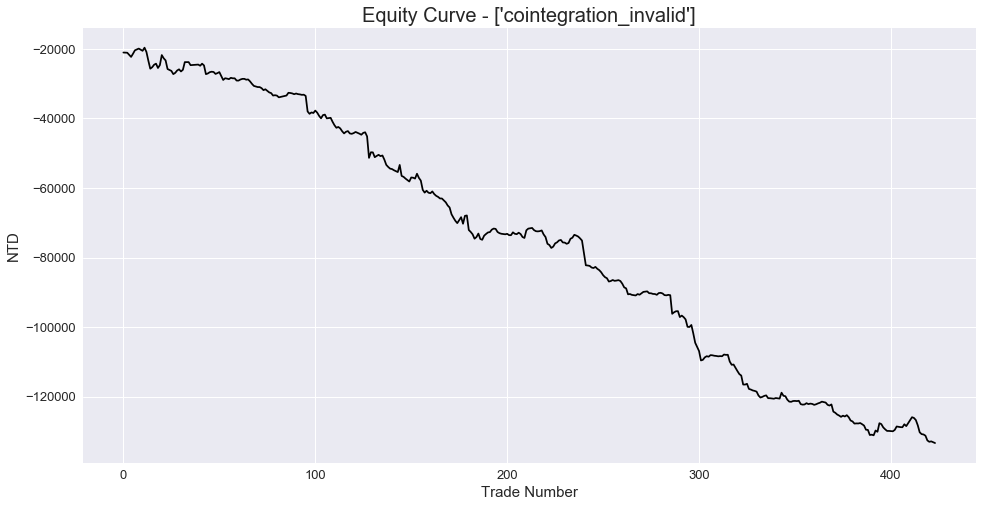

In [11]:
plot_equity_curve(['cointegration_invalid'])

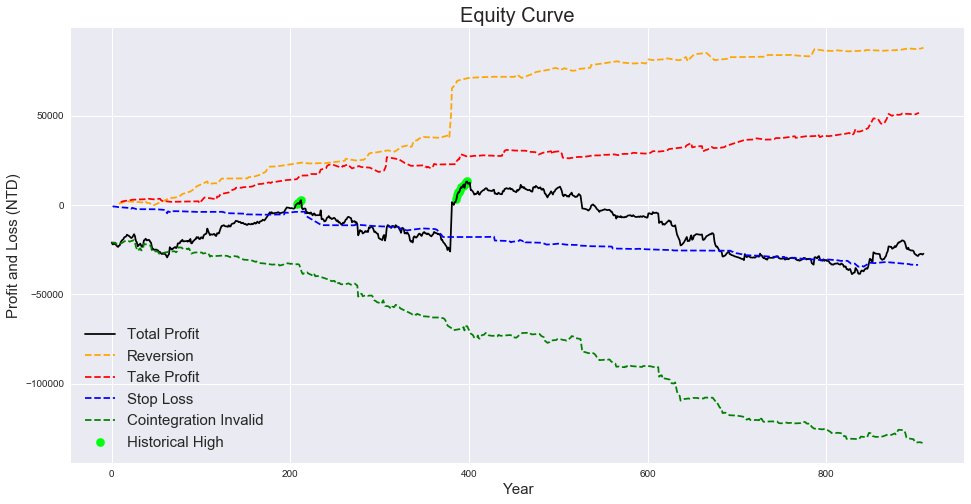

In [12]:
plt.figure(figsize=(16, 8))
accumulate_profit = trade_result.net_profit.values.cumsum()

# 找出創新高的index(要畫綠點)
new_highest_index = []
for i in range(len(accumulate_profit)):
    current_accumulate_profit = accumulate_profit[i]
    if i == 0:
        new_highest = accumulate_profit[i]
    if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
        new_highest = current_accumulate_profit
        new_highest_index.append(i)

# 權益曲線
plt.plot(accumulate_profit, c='black', label='Total Profit')
# 創新高的點
plt.scatter(new_highest_index,
            accumulate_profit[new_highest_index], c='#02ff0f', s=70,
            label='Historical High')

plt.plot(trade_result[trade_result.reason == 'reversion']['net_profit'].cumsum(),
         c='orange', ls='--', label='Reversion')
plt.plot(trade_result[trade_result.reason == 'take_profit']['net_profit'].cumsum(),
         c='red', ls='--', label='Take Profit')
plt.plot(trade_result[trade_result.reason == 'stop_loss']['net_profit'].cumsum(),
         c='blue', ls='--', label='Stop Loss')
plt.plot(trade_result[trade_result.reason == 'cointegration_invalid']['net_profit'].cumsum(),
         c='green', ls='--', label='Cointegration Invalid')

plt.legend(fontsize=15)
plt.title('Equity Curve', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Profit and Loss (NTD)', fontsize=15);

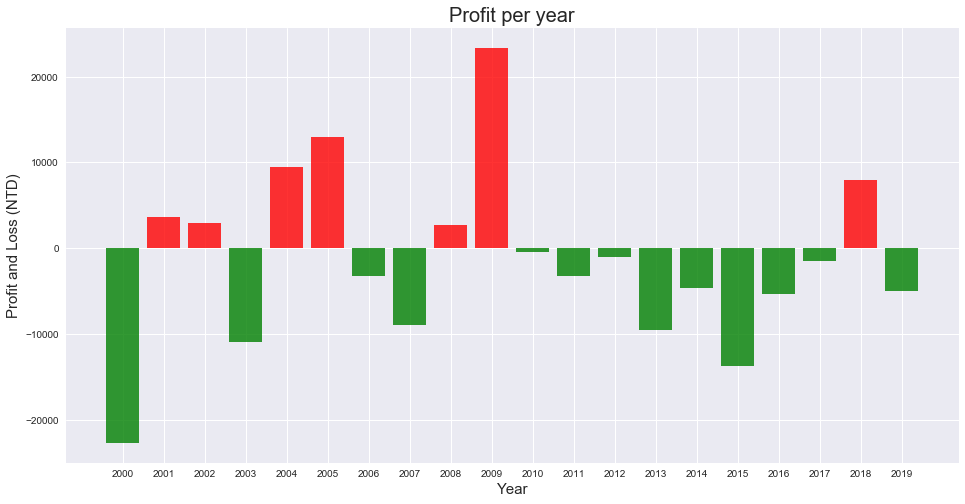

In [13]:
plt.figure(figsize=(16, 8))
trade_result['month'] = trade_result.date_in.apply(lambda x: x.month)
trade_result['year'] = trade_result.date_in.apply(lambda x: x.year)
temp = trade_result.groupby(['year'])['net_profit'].sum()

gain = temp[temp > 0]
loss = temp[temp <= 0]

plt.figure(figsize=(16, 8))
plt.bar(gain.index, gain, color='red', alpha=0.8)
plt.bar(loss.index, loss, color='green', alpha=0.8)
plt.xticks(list(map(lambda x: int(x), temp.index)))
plt.title('Profit per year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Profit and Loss (NTD)', fontsize=15);